In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# unzip the folder quietly
!unzip -q "drive/MyDrive/Hiring_Classification_Challenge/food-101.zip" 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys, gc, os, shutil, PIL
from tqdm.notebook import tqdm
seed = 42

import tensorflow as tf
print("tensorflow version", tf.__version__)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation

AUTOTUNE = tf.data.experimental.AUTOTUNE


tf.config.list_physical_devices('GPU')


tensorflow version 2.4.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
base_dir = "food-101/"

os.listdir(base_dir)

['train', 'README.txt', 'test', 'images', 'meta']

# list the number of classes

In [3]:
labels = []

with open (base_dir+"meta/classes.txt", 'r') as file:
    for cls in tqdm(file):
        labels.append(cls[:-1])
    
print("[INFO] Total number of classes", len(labels))
# print(labels)
gc.collect()


[INFO] Total number of classes 101


14

# Re-arrange dataset into training and testing folders

In [6]:
def create_train_test(folder):
    """ 
    creates subfolders for train and test under root dir
    copies files from subfolders(classes) under "/images" to subfolders of "/train" & "/test
    
    """

    # creates subfolders for train and test under root dir
    for cls in labels:
        os.makedirs(base_dir + folder + '/' + cls)
    
    # copies image files
    with open (base_dir+"meta/" + folder + ".txt", 'r') as file:
        for f in tqdm(file) :
            shutil.move(src=base_dir+"images/" + f[:-1]+ ".jpg", 
                        dst=base_dir+folder+"/" + f[:-1]+ ".jpg" )

            
create_train_test(folder="train" )
print("[INFO] subfolders created for train data")
create_train_test(folder="test" )
print("[INFO] subfolders created for test data")
gc.collect()


[INFO] subfolders created for train data



[INFO] subfolders created for test data


12

In [4]:
# see the newly created train/test folders
os.listdir(base_dir)

['train', 'README.txt', 'test', 'images', 'meta']

# List number of samples in training and testing folders.

`The list is too long...so this piece of code just prints total number of samples. `

`If we want to list all the files, we can set `
**list_files = True**

In [8]:
def list_and_count_files(folder, list_files=False):
    """ 
    lists number of samples in training and testing folders
    
    """
    counter = 0
    for root, dirs, files in os.walk(base_dir + folder + "/"):
        for file in files:
            if list_files:
                print(os.path.join(root,file))
        counter += len(files)
    print("[INFO] Total number of samples in {} folder".format(folder), counter)

# avoiding printing the all the file names in the display
# set list_files to true if needed to print file names
list_and_count_files(folder="train",list_files=False)
list_and_count_files(folder="test",list_files=False)
gc.collect()

[INFO] Total number of samples in train folder 75750
[INFO] Total number of samples in test folder 25250


151

# Plot sample images from training and testing folders.

In [9]:
def display_images(folder):
    """
    plots sample images from training and testing datasets.
    """
    _, axes_list = plt.subplots(5, 7, figsize=(15,10))
    for axes in axes_list:
        for ax in axes:
            ax.axis('off')
            lbl = np.random.choice(os.listdir(base_dir+folder+"/"))
            img = np.random.choice(os.listdir(base_dir+folder+"/" + lbl))
            ax.imshow(PIL.Image.open(base_dir+folder+"/" + lbl+"/"+img))
            ax.set_title(lbl)

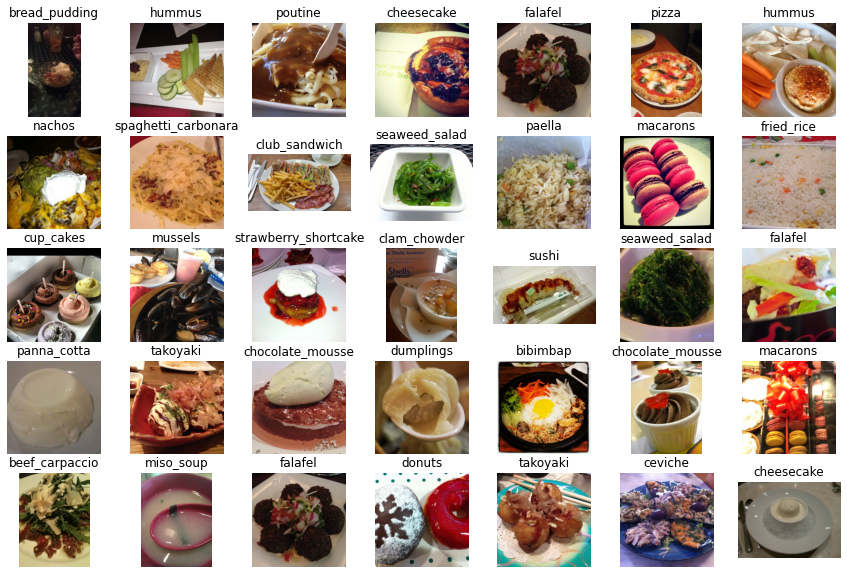

In [10]:
display_images(folder="train")

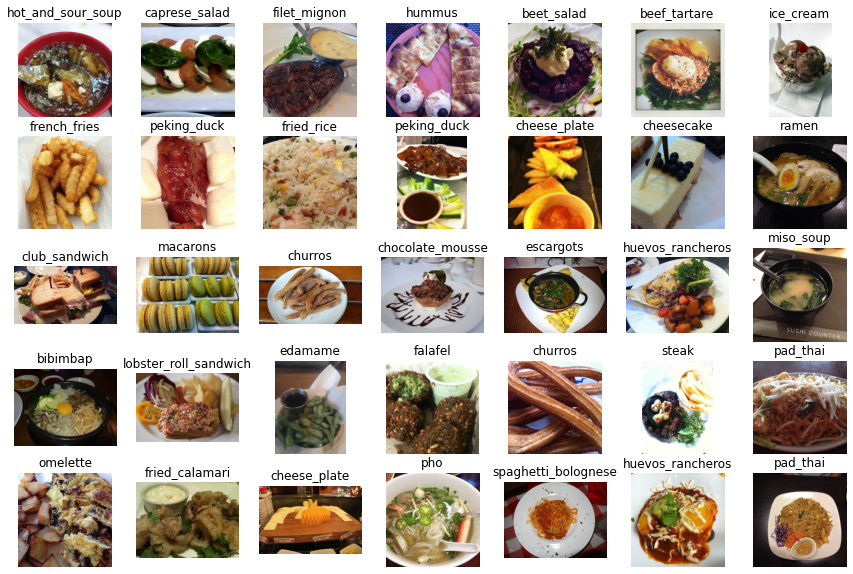

In [11]:
display_images(folder="test")

# create the train, val, test datasets.

In [5]:
# params
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 101
BATCH_SIZE = 16
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(os.path.join(base_dir,"train"),
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            shuffle=True,
                                            seed=seed,
                                            validation_split=0.2,
                                            subset="training")


val_dataset = image_dataset_from_directory(os.path.join(base_dir,"train"),
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            shuffle=True,
                                            seed=seed,
                                            validation_split=0.2,
                                            subset="validation")


test_dataset = image_dataset_from_directory(os.path.join(base_dir,"test"),
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            shuffle=True,
                                            seed=seed)

Found 75750 files belonging to 101 classes.
Using 60600 files for training.
Found 75750 files belonging to 101 classes.
Using 15150 files for validation.
Found 25250 files belonging to 101 classes.


# augment dataset

In [7]:
# craete a tensorflow layer for augmentation
data_augmentation = Sequential([RandomFlip('horizontal'),
                                RandomRotation(0.2)])

# Preview the preprocessed dataset.

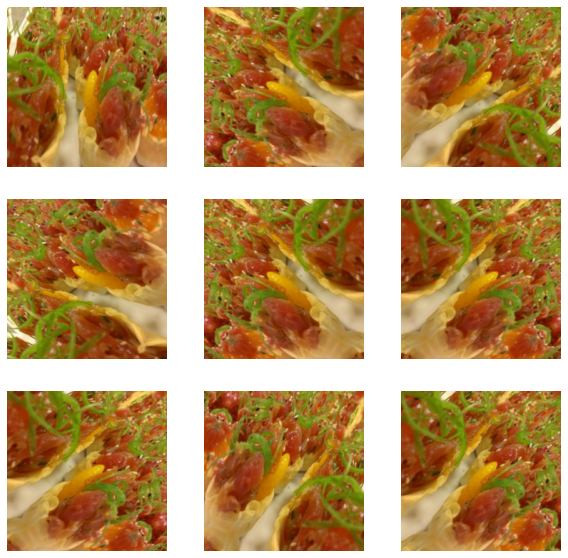

In [15]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# configure dataset for performance

In [8]:
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# load pretrained model

In [9]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                       include_top=False,
                       weights='imagenet')

print("[INFO] Number of layers in the base model MobileNet V2: ", 
      len(base_model.layers))

# freeze the base model
base_model.trainable = False

# print the base model summary
# print(base_model.summary())

[INFO] Number of layers in the base model MobileNet V2:  154


In [10]:
inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968

In [11]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      patience=1,
                                      verbose=1)
earlyStopping = EarlyStopping(monitor='val_accuracy',
                              patience=5)
checkpoint = ModelCheckpoint(os.path.join(base_dir,'base_model.h5'),
                                        monitor='val_accuracy',
                                        save_best_only=True)

# compile the model
model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train the model
history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=1, # INITIAL_EPOCHS
                    # callbacks=[reduceLROnPlateau,earlyStopping,checkpoint],
                    validation_data=val_dataset)

3788/3788 [==============================] - 504s 103ms/step - loss: 3.5444 - accuracy: 0.1876 - val_loss: 2.2510 - val_accuracy: 0.4364


In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# fine tuning

In [ ]:
# un-freeze the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# compile the model
model.compile(optimizer=RMSprop(lr=1e-5),
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])
print(model.summary())

In [ ]:
# train
history_fine = model.fit(train_dataset,
                        batch_size=BATCH_SIZE,
                        epochs=1, # TOTAL_EPOCHS,
                        # initial_epoch=history.epoch[-1],
                        callbacks=[earlyStopping,checkpoint],
                        validation_data=val_dataset)

In [ ]:
history_frame = pd.DataFrame(history_fine.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# evaluate on test dataset

In [ ]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)